In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

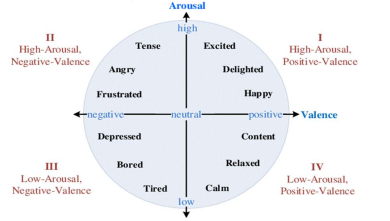

In [30]:
mood_names = [
    'Happy', 'Delighted', 'Excited',
    'Tense', 'Angry', 'Frustrated',
    'Depressed', 'Bored', 'Tired',
    'Calm', 'Relaxed', 'Content',
]
mood_count = len(mood_names)

We will use 2 variables to classify each song to corresponding mood.
We don't have Arousal, but we have energy column, so we can replace those as they represent similar thing.

To select other useful variables for our model we can read from [this](https://towardsdatascience.com/predicting-my-mood-using-my-spotify-data-2e898add122a) paper, that the acousticness
has the most impact on mood from the remaining variables.

In [31]:
data = pd.read_csv('tracks.csv')[['valence', 'energy', 'acousticness', 'song_name']]
data.head()

C:\Users\olafl\AppData\Local\Temp\ipykernel_14764\3415676746.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('tracks.csv')[['valence', 'energy', 'acousticness', 'song_name']]


,valence,energy,acousticness,song_name
0,0.3890,0.814,0.0598,Mercury: Retrograde
1,0.1240,0.493,0.4010,Pathology
2,0.0391,0.893,0.0138,Symbiote
3,0.1750,0.781,0.0237,ProductOfDrugs (Prod. The Virus and Antidote)
4,0.5910,0.624,0.2170,Venom


Spotify api pre-normalizes those values so we don't need to worry about it, but I will subtract 0.5 from valence and energy for easier plotting

In [32]:
data_classified = data.copy()
for i, row in data_classified.iterrows():
  data_classified.at[i, 'valence'] -= 0.5
  data_classified.at[i, 'energy'] -= 0.5

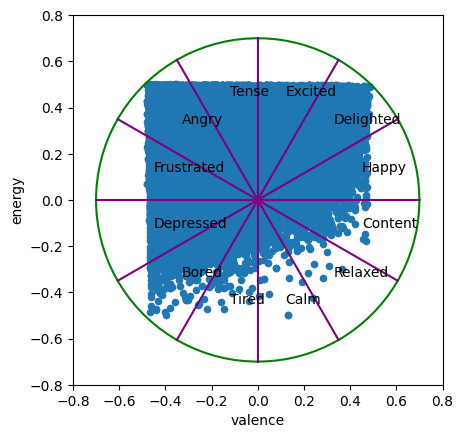

In [33]:
data_classified.plot(x='valence', y='energy', kind='scatter')

# Plot circle
r = 0.7 # arbitrarily bigger to fit all the data
plt.xlim(-(r+0.1), (r+0.1))
plt.ylim(-(r+0.1), (r+0.1))
plt.gca().set_aspect('equal')

angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
xs = r * np.cos(angles)
ys = r * np.sin(angles)
plt.plot(xs, ys, color = 'green')

# Plot boundaries and make list of areas of boundaries to classify songs
boundaries_dict = {}
for i in range(mood_count):
  plt.plot(
       [0, r * np.cos(i * np.pi/6)],
       [0, r * np.sin(i * np.pi/6)],
       color = "purple"
  )
  boundaries_dict[mood_names[i]] = [
      [0, 0],
      [r * np.cos(i * np.pi/6), r * np.sin(i * np.pi/6)],
      [r * np.cos((i+1) * np.pi/6), r * np.sin((i+1) * np.pi/6)]
  ]
  plt.gca().annotate(mood_names[i], xy=(r/1.5 * np.cos((i+0.5) * np.pi/6), r/1.5 * np.sin((i+0.5) * np.pi/6)), xycoords='data', fontsize=10, )

In [34]:
# classify songs
def point_in_triangle(p, v1, v2, v3):
    def _test(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])

    b1 = _test(p, v1, v2) < 0.0
    b2 = _test(p, v2, v3) < 0.0
    b3 = _test(p, v3, v1) < 0.0

    return (b1 == b2) and (b2 == b3)

data_classified['mood'] = None
for i, row in data_classified.iterrows():
    x, y = data_classified.at[i, 'valence'], data_classified.at[i, 'energy']

    for key, value in boundaries_dict.items():
      point=[x, y]
      if point_in_triangle(p=point, v1=value[0], v2=value[1], v3=value[2]):
        data_classified.at[i, 'mood'] = key
        continue

data_classified.head()

,valence,energy,acousticness,song_name,mood
0,-0.1110,0.314,0.0598,Mercury: Retrograde,Tense
1,-0.3760,-0.007,0.4010,Pathology,Depressed
2,-0.4609,0.393,0.0138,Symbiote,Angry
3,-0.3250,0.281,0.0237,ProductOfDrugs (Prod. The Virus and Antidote),Angry
4,0.0910,0.124,0.2170,Venom,Delighted


To not have bias towards any mood we need to equalize number of samples per each

([<matplotlib.axis.XTick at 0x164aaa9ea40>,
 [Text(0, 0, 'Happy'),
  Text(1, 0, 'Delighted'),
  Text(2, 0, 'Excited'),
  Text(3, 0, 'Tense'),
  Text(4, 0, 'Angry'),
  Text(5, 0, 'Frustrated'),
  Text(6, 0, 'Depressed'),
  Text(7, 0, 'Bored'),
  Text(8, 0, 'Tired'),
  Text(9, 0, 'Calm'),
  Text(10, 0, 'Relaxed'),
  Text(11, 0, 'Content')])

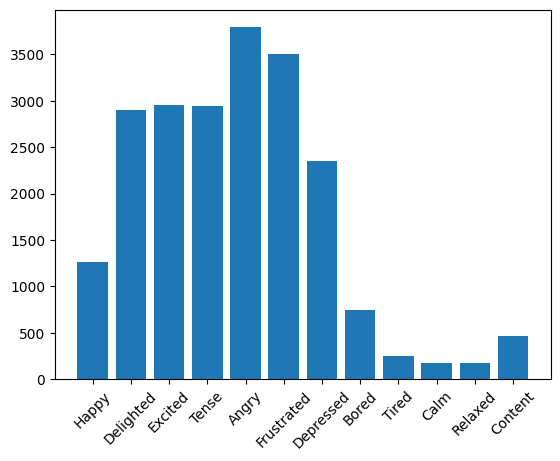

In [35]:
moods_count = {}
for mood in mood_names:
    moods_count[mood] = len(data_classified.where(data_classified['mood'] == mood).dropna())

plt.bar(range(len(moods_count)), list(moods_count.values()), align='center')
plt.xticks(np.arange(0, 12, step=1), mood_names, rotation = 45)

In [36]:
n_samples_per_mood = min(moods_count.values())

In [37]:
data_classified_equalized = pd.DataFrame()

for mood in mood_names:
    data_classified_equalized = pd.concat([
        data_classified_equalized,
        pd.DataFrame(data_classified.where(data_classified['mood'] == mood).dropna().sample(n=n_samples_per_mood))
    ])

data_classified_equalized.head()

,valence,energy,acousticness,song_name,mood
14204,0.185,0.102,0.1230,Hold On,Happy
1656,0.206,0.064,0.0187,HELP,Happy
936,0.200,0.051,0.4610,Dyin Slowly,Happy
14004,0.069,0.037,0.3700,Speciaal,Happy
8109,0.265,0.142,0.1020,Hip Hop Hooray,Happy


The data still won't be perfect as some of the moods have a lot more variance, but we have to deal with this

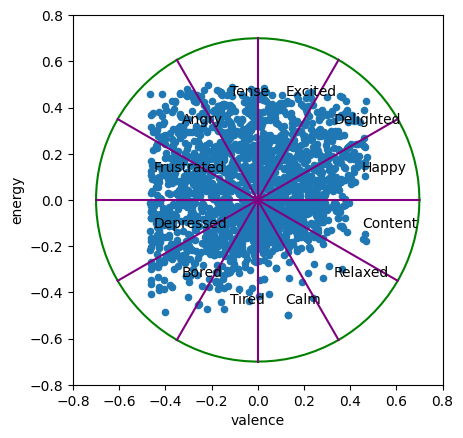

In [38]:
data_classified_equalized.plot(x='valence', y='energy', kind='scatter')

# Plot circle
r = 0.7 # arbitrarily bigger to fit all the data
plt.xlim(-(r+0.1), (r+0.1))
plt.ylim(-(r+0.1), (r+0.1))
plt.gca().set_aspect('equal')

angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
xs = r * np.cos(angles)
ys = r * np.sin(angles)
plt.plot(xs, ys, color = 'green')

# Plot boundaries and make list of areas of boundaries to classify songs
boundaries_dict = {}
for i in range(mood_count):
  plt.plot(
       [0, r * np.cos(i * np.pi/6)],
       [0, r * np.sin(i * np.pi/6)],
       color = "purple"
  )
  plt.gca().annotate(mood_names[i], xy=(r/1.5 * np.cos((i+0.5) * np.pi/6), r/1.5 * np.sin((i+0.5) * np.pi/6)), xycoords='data', fontsize=10, )

Now we have to split into train and test datasets (we don't have enough data for validation set)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    data_classified_equalized[['valence', 'energy', 'acousticness']], data_classified_equalized['mood'],
    test_size=0.2, random_state=42
)
X_train

,valence,energy,acousticness
7093,0.1460,0.057,0.04290
10674,-0.0200,0.198,0.18000
17861,-0.0540,-0.291,0.76500
599,0.4630,0.229,0.00211
16409,0.1330,0.186,0.17300
...,...,...,...
16632,0.0110,-0.199,0.19500
438,-0.4661,-0.015,0.83400
5573,-0.1630,-0.085,0.40500
11488,-0.4457,-0.284,0.64900


In [40]:
y_train

7093         Happy
10674        Tense
17861        Tired
599          Happy
16409    Delighted
           ...    
16632         Calm
438      Depressed
5573     Depressed
11488        Bored
3670         Angry
Name: mood, Length: 1670, dtype: object

Turn data back to normalized

In [41]:
for i, row in data_classified.iterrows():
  data_classified.at[i, 'valence'] += 0.5
  data_classified.at[i, 'energy'] += 0.5

for i, row in X_train.iterrows():
  X_train.at[i, 'valence'] += 0.5
  X_train.at[i, 'energy'] += 0.5

for i, row in X_test.iterrows():
  X_test.at[i, 'valence'] += 0.5
  X_test.at[i, 'energy'] += 0.5

Now we just need to save data to csv for model to train on

In [42]:
data_classified_equalized.to_csv('data_classified_equalized.csv')
X_train.to_csv("X_train.csv")
X_test.to_csv("X_test.csv")
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")